In [1]:
import pandas as pd
import numpy as np
import catboost
import matplotlib.pyplot as plt
from sklearn import metrics
from rdkit import Chem
from CDK_pywrapper import CDK
from sklearn.model_selection import KFold, GroupKFold
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_excel("Viscosity_dataset.xlsx")

In [3]:
#Calculation and filtering of descriptors for HBA
mols_nba = [Chem.AddHs(Chem.MolFromSmiles(smiles)) for smiles in df["HBA"].dropna()]

cdk = CDK()
cdk_nba = (cdk.calculate(mols_nba)
              .set_index(df["HBA"].dropna().index)
              .fillna(0)
              .loc[:, lambda x: ~np.isinf(x).any()]
              .loc[:, lambda x: (x != 0).any(axis=0)])

corr = cdk_nba.corr().applymap(lambda x: 0 if x == 1 else x)
list_desc_nba = corr[(corr <= 0.95)].dropna().index.tolist()

print('Number of descriptors HBA:', len(list_desc_nba) - 1)

The Chemistry Development Kit (CDK) is a collection of modular Java libraries
for processing chemical information (Cheminformatics). It can compute 14 different fingerprint
types and 287 molecular descriptors (it requires 3D molecular structures for the latter).

###################################

Should you publish results based on the PaDEL descriptors,
please cite:

Willighagen et al., (2017)  J. Cheminf. 9(3), doi:10.1186/s13321-017-0220-4,
May and Steinbeck., (2014) J. Cheminf., doi:10.1186/1758-2946-6-3,
Steinbeck et al., (2006) Curr. Pharm. Des. 12(17):2111-2120, doi:10.2174/138161206777585274,
Steinbeck et al., (2003) J. Chem. Inf. Comput. Sci. 43(2):493-500, doi:10.1021/ci025584y.

###################################


Number of descriptors HBA: 75


In [4]:
#Calculation and filtering of descriptors for HBD
mols_nbd = [Chem.AddHs(Chem.MolFromSmiles(smiles)) for smiles in df["HBD"].dropna()]

cdk = CDK()
cdk_nbd = (cdk.calculate(mols_nbd)
              .set_index(df["HBD"].dropna().index)
              .fillna(0)
              .loc[:, lambda x: ~np.isinf(x).any()]
              .loc[:, lambda x: (x != 0).any(axis=0)])

corr = cdk_nbd.corr().applymap(lambda x: 0 if x == 1 else x)
list_desc_nbd = corr[(corr <= 0.95)].dropna().index.tolist()

print('Number of descriptors HBD:', len(list_desc_nbd) - 1)

The Chemistry Development Kit (CDK) is a collection of modular Java libraries
for processing chemical information (Cheminformatics). It can compute 14 different fingerprint
types and 287 molecular descriptors (it requires 3D molecular structures for the latter).

###################################

Should you publish results based on the PaDEL descriptors,
please cite:

Willighagen et al., (2017)  J. Cheminf. 9(3), doi:10.1186/s13321-017-0220-4,
May and Steinbeck., (2014) J. Cheminf., doi:10.1186/1758-2946-6-3,
Steinbeck et al., (2006) Curr. Pharm. Des. 12(17):2111-2120, doi:10.2174/138161206777585274,
Steinbeck et al., (2003) J. Chem. Inf. Comput. Sci. 43(2):493-500, doi:10.1021/ci025584y.

###################################


Number of descriptors HBD: 79


In [5]:
des_nba = cdk_nba[list_desc_nba].multiply(df['x_HBA'], axis=0)
des_nbd = cdk_nbd[list_desc_nbd].multiply(df['x_HBD'], axis=0)

In [6]:
X = pd.concat([df["Temperature"], des_nba, des_nbd], axis=1, join="inner").values
y = df["Viscosity"]

## "Data-points" validation

In [7]:
Y_pred, Y_true = [], []
average_relative_deviations = []
cv = KFold(n_splits=5, shuffle=True, random_state=1)
for train_index, test_index in cv.split(X):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    cb = CatBoostRegressor(silent=True, iterations = 962, learning_rate = 0.17426268264230108, depth = 5, l2_leaf_reg = 0.0010806402651556, 
                                       random_strength = 0.001346366301850135, bagging_temperature = 0.5387819112081171, border_count=68)
    cb.fit(x_train, y_train)
    
    y_pred = cb.predict(x_test)
    Y_pred.extend(y_pred)
    Y_true.extend(y_test)
    
    relative_deviation = np.abs((y_test - y_pred) / y_test).mean() * 100
    average_relative_deviations.append(relative_deviation)
    
print(f'R^2 = {metrics.r2_score(Y_true, Y_pred):.3f}')
print(f'RMSE = {metrics.mean_squared_error(Y_true, Y_pred, squared=False):.4f}')
print(f'MAE = {mean_absolute_error(Y_true, Y_pred):.3f}')
print(f'AARD = {np.mean(average_relative_deviations):.3f}')

R^2 = 0.979
RMSE = 0.1072
MAE = 0.046
AARD = 2.535


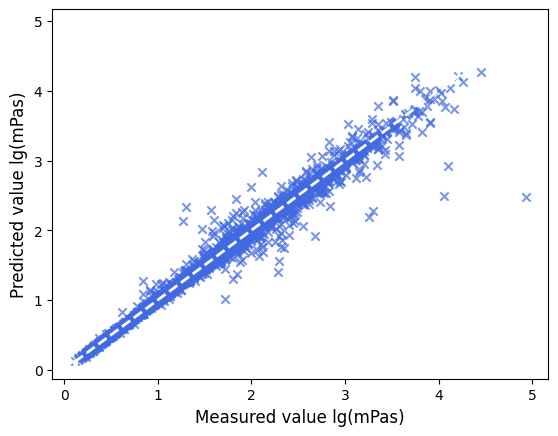

In [8]:
fig, ax = plt.subplots()
ax.scatter(Y_true, Y_pred, color='#4169e1', edgecolors='#000080', alpha=0.7, marker='x')
ax.plot([y.min(), y.max()], [y.min(), y.max()], "w--.", lw=2)
ax.set_xlabel("Measured value lg(mPas)", fontsize=12, color='black')
ax.set_ylabel("Predicted value lg(mPas)", fontsize=12, color='black')
plt.show()

## “Mixture” validation

In [9]:
class UniqueGroupKFold:
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        unique_groups = np.unique(groups)
        if self.shuffle:
            np.random.seed(self.random_state)
            np.random.shuffle(unique_groups)
        
        fold_size = len(unique_groups) // self.n_splits
        
        for i in range(self.n_splits):
            if i == self.n_splits - 1:
                test_groups = unique_groups[i * fold_size:]
            else:
                test_groups = unique_groups[i * fold_size: (i + 1) * fold_size]
            
            test_indices = np.where(np.isin(groups, test_groups))[0]
            train_indices = np.where(~np.isin(groups, test_groups))[0]
            
            if len(test_indices) > 0 and len(train_indices) > 0:
                yield train_indices, test_indices

In [10]:
Y_pred, Y_true = [], []
average_relative_deviations = []
cv = UniqueGroupKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in cv.split(X, groups=df['MOLECULEID']):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    cb = CatBoostRegressor(silent=True)
    cb.fit(x_train, y_train)
    
    y_pred = cb.predict(x_test)
    Y_pred.extend(y_pred)
    Y_true.extend(y_test)
    
    relative_deviation = np.abs((y_test - y_pred) / y_test).mean() * 100
    average_relative_deviations.append(relative_deviation)
    
print(f'R^2 = {metrics.r2_score(Y_true, Y_pred):.3f}')
print(f'RMSE = {metrics.mean_squared_error(Y_true, Y_pred, squared=False):.4f}')
print(f'MAE = {mean_absolute_error(Y_true, Y_pred):.3f}')
print(f'AARD = {np.mean(average_relative_deviations):.3f}')

R^2 = 0.844
RMSE = 0.2909
MAE = 0.217
AARD = 14.393


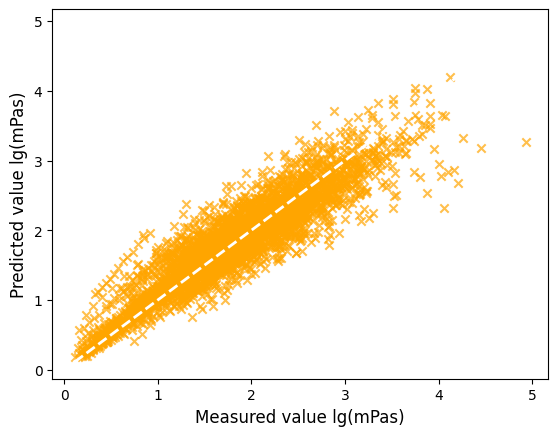

In [11]:
fig, ax = plt.subplots()
ax.scatter(Y_true, Y_pred, color='#ffa500', edgecolors='#ff4500', alpha=0.7, marker='x')
ax.plot([y.min(), y.max()], [y.min(), y.max()], "w--.", lw=2)
ax.set_xlabel("Measured value lg(mPas)", fontsize=12, color='black')
ax.set_ylabel("Predicted value lg(mPas)", fontsize=12, color='black')
plt.show()

## “Components” validation

In [12]:
nba_mapping = {v: i for i, v in enumerate(df['HBA'].unique(), 1)}
nbd_mapping = {v: i for i, v in enumerate(df['HBD'].unique(), 1)}
df['ind_A'] = df['HBA'].map(nba_mapping)
df['ind_D'] = df['HBD'].map(nbd_mapping)

In [13]:
def evaluate_model(X, y, groups):
    Y_pred, Y_true = [], []
    average_relative_deviations = []
    cv = UniqueGroupKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_index, test_index in cv.split(X, groups=groups):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        cb = CatBoostRegressor(silent=True)
        cb.fit(x_train, y_train)
        
        y_pred = cb.predict(x_test)
        Y_pred.extend(y_pred)
        Y_true.extend(y_test)
        
        relative_deviation = np.abs((y_test - y_pred) / y_test).mean() * 100
        average_relative_deviations.append(relative_deviation)
    
    r2 = metrics.r2_score(Y_true, Y_pred)
    rmse = metrics.mean_squared_error(Y_true, Y_pred, squared=False)
    mae = mean_absolute_error(Y_true, Y_pred)
    aard = np.mean(average_relative_deviations)
    
    return r2, rmse, mae, aard


metrics_A = evaluate_model(X, y, df['ind_A'])
metrics_D = evaluate_model(X, y, df['ind_D'])


av_metrics = [(a + b) / 2 for a, b in zip(metrics_A, metrics_D)]


print(f'R^2 = {av_metrics[0]:.3f}')
print(f'RMSE = {av_metrics[1]:.4f}')
print(f'MAE = {av_metrics[2]:.3f}')
print(f'AARD = {av_metrics[3]:.3f}')

R^2 = 0.682
RMSE = 0.4148
MAE = 0.309
AARD = 20.801
